In [1]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem import MeshLine, ElementLineP1, Basis, BilinearForm, LinearForm
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

import pytensor.tensor.subtensor as subtensor
import pytensor.tensor as tensor
import pytensor.sparse as sparsetensor
import arviz as az

import scienceplots
# plot params
contour_levels = 20
plt.style.use(['science', 'grid'])
color_list = [(253, 231, 37),(194, 223, 35),(134, 213, 73),(82, 197, 105),(42, 176, 127),(30, 155, 138),(37, 133, 142),(45, 112, 142),(56, 88, 140),(67, 62, 133),(72, 33, 115),(68, 1, 84)]
color_list = [tuple(ti/255 for ti in t) for t in color_list]

In [2]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 400

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = -6.
x_axis_right_boundary = 6.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.02
t_end = 5.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

true_nu = 0.01

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

newton_tol = 0.00001

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*true_coordinates).flatten()
#u_0 = np.exp((-(true_coordinates.flatten())**2)/2)
u_0true = np.exp(-((true_coordinates.flatten()-1)**2)/2) - np.exp(-((true_coordinates.flatten()+1)**2)/2) 
u_strue = np.zeros((number_of_steps, n_x))
u_strue[0,:] = u_0true

u_guess = u_0true + np.random.normal(0, 0.001, len(u_0true))
u_guess[0] = u_guess[-1] = 0

In [3]:
# Observation Parameters
sigma_n_true = 0.05
spatial_points = 52
temporal_points = 2

temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+2, dtype=int)
spatial_measurement_indices = temp[1:-1]
spatial_measurement_coordinates = true_coordinates[spatial_measurement_indices]
temp = np.linspace(0, len(time_range) - 1, temporal_points+2, dtype=int)
temporal_measurement_indices = temp[1:-1]
temporal_measurement_coordinates = time_range[temporal_measurement_indices]

In [4]:
# CRANK NICHOLSON

@fem.BilinearForm
def A_build(u,v,w):
    return u*v

A_mat = A_build.assemble(basis).toarray()
A_mat[:,0] = A_mat[:,-1] = 0.
A_mat[0,:] = A_mat[-1,:] = 0.
A_mat[0,0] = 1e3
A_mat[-1,-1] = 1e3
# A_mat = scsparse.csr_matrix(A_mat)

@fem.BilinearForm
def B_build(u,v,w):
    return grad(u)[0]*v

B_mat = B_build.assemble(basis).toarray()
B_mat[:,0] = B_mat[:,-1] = 0.
B_mat[0,:] = B_mat[-1,:] = 0.
B_mat[0,0] = 1e3
B_mat[-1,-1] = 1e3
# B_mat = scsparse.csr_matrix(B_mat)

@fem.BilinearForm
def C_build(u,v,w):
    return dot(grad(u),grad(v))

C_mat = C_build.assemble(basis).toarray()
C_mat[:,0] = C_mat[:,-1] = 0.
C_mat[0,:] = C_mat[-1,:] = 0.
C_mat[0,0] = 1e3
C_mat[-1,-1] = 1e3
# C_mat = scsparse.csr_matrix(C_mat)

In [49]:
import pytensor.tensor as at
from pytensor import function, scan, shared, config, printing, sparse, graph
import numpy as np
from tqdm import tqdm
import jax as jx
import jax.numpy as jnp
import jax.scipy as jsp
import pymc.sampling_jax
from jax.experimental import sparse as jxsparse
from pytensor.link.jax.dispatch import jax_funcify

def jax_sparse_evolve_guess(nu, u_guess, u_prev, dt=dt, A_mat=A_mat, B_mat=B_mat, C_mat=C_mat):
    u_sum = u_guess + u_prev
    u_dif = u_guess - u_prev
    resid = A_mat @ u_dif + (dt/4)*B_mat @ u_sum**2 + (dt*nu/2) * C_mat @ u_sum
    jacobian = A_mat + (dt/2)*B_mat @ u_sum + (dt*nu/2) * C_mat
    nse = jnp.count_nonzero(jacobian)
    lhs_sparse_matrix = jxsparse.BCSR.fromdense(jacobian, nse=nse)
    return u_guess + jxsparse.linalg.spsolve(lhs_sparse_matrix.data,lhs_sparse_matrix.indices,lhs_sparse_matrix.indptr, -resid)

class SparseSolve(at.Op):
    __props__ = ()

    def make_node(self, A, b):
        A = at.as_tensor_variable(A)
        b = at.as_tensor_variable(b)
        return graph.basic.Apply(self, [A, b], [b.type()])
    
    def perform(self, node, inputs, outputs):
        A, b = inputs
        x = scsparse.linalg.spsolve(A, b)
        outputs[0][0] = x

    def infer_shape(self, fgraph, node, input_shapes):
        return [input_shapes[1]]

sparse_solve = SparseSolve()

In [54]:
nu_test = 0.01

u_sum = u_guess + u_0true
u_dif = u_guess - u_0true
resid = A_mat @ u_dif + (dt/4)*B_mat @ u_sum**2 + (dt*nu_test/2) * C_mat @ u_sum
jacobian = A_mat + (dt/2)*B_mat @ u_sum + (dt*nu_test/2) * C_mat

In [50]:
jax_sparse_evolve_guess(0.1, u_guess, u_0true)

Array([-3.72456247e-06, -1.13917610e-04, -1.58368578e-04, -1.75398870e-04,
       -1.82549398e-04, -1.85852285e-04, -1.87886598e-04, -1.89674031e-04,
       -1.91467801e-04, -1.93432750e-04, -1.95653683e-04, -1.98180393e-04,
       -2.01105439e-04, -2.04449555e-04, -2.08211226e-04, -2.12458892e-04,
       -2.17209059e-04, -2.22694289e-04, -2.29035444e-04, -2.36205186e-04,
       -2.44392577e-04, -2.53445876e-04, -2.63691945e-04, -2.75459546e-04,
       -2.88738217e-04, -3.03753715e-04, -3.20684762e-04, -3.39598030e-04,
       -3.60946360e-04, -3.84991022e-04, -4.11979518e-04, -4.42424145e-04,
       -4.76375528e-04, -5.14345889e-04, -5.57061771e-04, -6.04650003e-04,
       -6.57735113e-04, -7.17181241e-04, -7.83452974e-04, -8.57235125e-04,
       -9.39425474e-04, -1.03045832e-03, -1.13158493e-03, -1.24408726e-03,
       -1.36859378e-03, -1.50657433e-03, -1.65944967e-03, -1.82802219e-03,
       -2.01422467e-03, -2.22039247e-03, -2.44700966e-03, -2.69585162e-03,
       -2.96924281e-03, -

In [51]:
jitted_guess_grad = jx.jit(jx.grad(jax_sparse_evolve_guess))

In [53]:
jitted_guess_grad(0.01, u_guess, u_0true)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[].

The error arose for the nse argument of bcsr_fromdense. In order for
BCSR.fromdense() to be used in traced/compiled code, you must pass a concrete
value to the nse (number of stored elements) argument.

The error occurred while tracing the function jax_sparse_evolve_guess at /tmp/ipykernel_354507/3303908608.py:12 for jit. This concrete value was not available in Python because it depends on the values of the arguments nu, u_guess, and u_prev.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [40]:
jitted_guess_grad(0.01, jnp.asarray(u_guess), jnp.asarray(u_0true))

ValueError: Non-hashable static arguments are not supported. An error occurred during a call to 'jax_sparse_evolve_guess' while trying to hash an object of type <class 'jaxlib.xla_extension.ArrayImpl'>, [ 0.00000000e+00  7.18683215e-04 -2.28921030e-03 -9.88255830e-06
 -1.26506835e-03 -1.68224348e-03  1.41474391e-03  1.05367223e-03
  1.25972224e-03 -7.23886226e-04  9.90528780e-04  2.37093230e-04
 -5.97713947e-05  4.34214463e-05 -1.11824188e-03 -1.15858908e-03
  1.78987489e-03  3.74200372e-04 -8.89403524e-04 -1.81888353e-04
 -5.72428264e-04 -1.90073076e-03  9.62806693e-04  9.63747445e-04
 -2.60808463e-04  2.32082130e-04 -5.10420320e-04 -1.55286532e-03
  3.20961748e-04 -1.31164662e-03 -7.79408505e-06 -2.05428058e-05
 -1.45559362e-03 -8.73608943e-04  2.01531472e-04 -1.55040461e-03
 -4.90015761e-04  9.56757144e-04  1.66991533e-04 -1.65180396e-04
  6.75094261e-04 -1.83372470e-03 -3.47936661e-06 -7.38879219e-04
 -8.41469705e-04 -3.88578331e-04 -3.51946394e-04 -1.95792960e-03
 -1.06197052e-03 -1.23987903e-03 -3.30897871e-03 -3.75445289e-03
 -4.53034606e-03 -4.05423347e-03 -3.96581705e-03 -4.12205372e-03
 -2.00866793e-03 -4.42802760e-03 -4.20220312e-03 -6.34215298e-03
 -6.96603591e-03 -6.33401092e-03 -8.10418307e-03 -9.12169883e-03
 -8.33008134e-03 -1.02798987e-02 -1.09293308e-02 -1.22330864e-02
 -1.14635067e-02 -1.61347086e-02 -1.61162986e-02 -1.65416239e-02
 -1.97814771e-02 -1.87852240e-02 -2.17684330e-02 -2.35406292e-02
 -2.66585316e-02 -2.80715302e-02 -2.93155814e-02 -3.06954674e-02
 -3.54054271e-02 -3.84490088e-02 -4.12405340e-02 -4.28423921e-02
 -4.68719747e-02 -5.08264913e-02 -5.29988901e-02 -5.85331215e-02
 -6.18570585e-02 -6.74813631e-02 -6.89735428e-02 -7.76718688e-02
 -8.22431776e-02 -8.95316618e-02 -9.44538304e-02 -9.98136980e-02
 -1.06650626e-01 -1.14770222e-01 -1.21019633e-01 -1.29220075e-01
 -1.38237846e-01 -1.46581498e-01 -1.53025757e-01 -1.62207863e-01
 -1.70729090e-01 -1.82719245e-01 -1.92587015e-01 -2.04505547e-01
 -2.15014053e-01 -2.26723613e-01 -2.36802772e-01 -2.49047949e-01
 -2.60457068e-01 -2.76483277e-01 -2.88601086e-01 -3.04642104e-01
 -3.16838608e-01 -3.31322762e-01 -3.46606330e-01 -3.61138715e-01
 -3.77163930e-01 -3.93139231e-01 -4.08978834e-01 -4.25030591e-01
 -4.40834575e-01 -4.58053743e-01 -4.74225227e-01 -4.91886313e-01
 -5.07446998e-01 -5.26240832e-01 -5.45008694e-01 -5.62252370e-01
 -5.76619476e-01 -5.95966952e-01 -6.13739674e-01 -6.29776044e-01
 -6.48354513e-01 -6.61345959e-01 -6.78258563e-01 -6.95693280e-01
 -7.12246485e-01 -7.27429835e-01 -7.41741300e-01 -7.57413417e-01
 -7.70864386e-01 -7.85325934e-01 -7.97024742e-01 -8.10705165e-01
 -8.21062051e-01 -8.31897642e-01 -8.44117764e-01 -8.49660117e-01
 -8.60738249e-01 -8.68371204e-01 -8.75768258e-01 -8.78237492e-01
 -8.84638532e-01 -8.87610161e-01 -8.89256586e-01 -8.90920206e-01
 -8.93129215e-01 -8.90159981e-01 -8.87135017e-01 -8.84362862e-01
 -8.80732524e-01 -8.73229479e-01 -8.65581810e-01 -8.60844114e-01
 -8.49224441e-01 -8.36630426e-01 -8.26756360e-01 -8.11873477e-01
 -7.95292862e-01 -7.79679678e-01 -7.63193477e-01 -7.43609396e-01
 -7.25507433e-01 -7.04142791e-01 -6.82216643e-01 -6.59036291e-01
 -6.34128700e-01 -6.07340051e-01 -5.83032121e-01 -5.55139117e-01
 -5.26645278e-01 -4.96916459e-01 -4.65541530e-01 -4.35498804e-01
 -4.04592313e-01 -3.71941002e-01 -3.39533051e-01 -3.03270293e-01
 -2.69688764e-01 -2.33735576e-01 -1.97778703e-01 -1.63532627e-01
 -1.27620067e-01 -9.14528547e-02 -5.61058798e-02 -1.89210391e-02
  1.76260274e-02  5.40008053e-02  9.22060809e-02  1.26223069e-01
  1.63819049e-01  1.98689540e-01  2.35293518e-01  2.69309667e-01
  3.05072665e-01  3.37176929e-01  3.70245754e-01  4.04034911e-01
  4.35576568e-01  4.65737723e-01  4.95815133e-01  5.24930394e-01
  5.53001595e-01  5.84045692e-01  6.08888705e-01  6.34424823e-01
  6.58456552e-01  6.81590531e-01  7.05562305e-01  7.27666383e-01
  7.44127373e-01  7.63554983e-01  7.82787917e-01  7.98952404e-01
  8.13267698e-01  8.24612482e-01  8.37359380e-01  8.47837934e-01
  8.60083480e-01  8.66042064e-01  8.72752208e-01  8.80481843e-01
  8.82990323e-01  8.85291309e-01  8.91749652e-01  8.90850390e-01
  8.92253098e-01  8.91272143e-01  8.87395649e-01  8.84306133e-01
  8.80170729e-01  8.72129699e-01  8.68903949e-01  8.58711235e-01
  8.52606331e-01  8.40639552e-01  8.32298051e-01  8.21175741e-01
  8.10221169e-01  7.98297975e-01  7.83131363e-01  7.69834070e-01
  7.57411614e-01  7.42440784e-01  7.28066811e-01  7.13916526e-01
  6.96727892e-01  6.79254733e-01  6.63172461e-01  6.47392833e-01
  6.30890374e-01  6.10690154e-01  5.96054642e-01  5.79187931e-01
  5.62090281e-01  5.44338889e-01  5.27409726e-01  5.09647417e-01
  4.92342868e-01  4.75823575e-01  4.59687651e-01  4.40953375e-01
  4.25640028e-01  4.09507533e-01  3.93308122e-01  3.76905663e-01
  3.60724662e-01  3.46858742e-01  3.33076096e-01  3.16809780e-01
  3.02484914e-01  2.89099510e-01  2.76323085e-01  2.63025038e-01
  2.49143041e-01  2.37019322e-01  2.25367471e-01  2.15537068e-01
  2.04622905e-01  1.92283482e-01  1.82119524e-01  1.70377511e-01
  1.63633026e-01  1.54032025e-01  1.46853503e-01  1.37619480e-01
  1.28971433e-01  1.22402763e-01  1.12450658e-01  1.07645213e-01
  1.01023651e-01  9.47230612e-02  8.93166216e-02  8.30867124e-02
  7.66228222e-02  7.25009792e-02  6.79240263e-02  6.27572323e-02
  5.49680553e-02  5.23540678e-02  5.07372905e-02  4.65446697e-02
  4.23682059e-02  3.92971874e-02  3.77239665e-02  3.36049310e-02
  3.28453899e-02  2.97203119e-02  2.86887800e-02  2.45732514e-02
  2.31235890e-02  2.25530328e-02  1.86934525e-02  1.86449755e-02
  1.59064631e-02  1.67834705e-02  1.49633487e-02  1.34836538e-02
  1.16362202e-02  9.64981723e-03  1.01730941e-02  8.07842886e-03
  9.44593161e-03  7.87971734e-03  7.99151004e-03  5.85883056e-03
  3.84017308e-03  3.16929559e-03  5.01619145e-03  2.78808847e-03
  3.77822779e-03  3.03391868e-03  3.22105505e-03  2.82154861e-03
  2.06148062e-03  1.38234248e-03  1.52282079e-03  2.54030422e-03
  1.17195071e-03  3.48410034e-04 -1.33199211e-03  1.68483249e-03
  2.00797152e-03  2.38040262e-03  2.64632752e-03  5.92069078e-04
 -1.14037909e-03  9.94179085e-04  2.57723446e-04  8.88108672e-04
  8.58163715e-04  8.16493613e-04  1.09789929e-04  8.83163166e-04
  1.26520772e-03  5.15750142e-04 -1.64376176e-03  1.86578508e-03
 -8.04664964e-04 -4.69267994e-04 -4.84460124e-05  9.73591251e-04
  4.24653085e-04 -1.18354497e-03 -1.65895428e-03  1.24274794e-03
 -1.13437943e-04  9.13763103e-04  1.91940357e-04  1.17331237e-03
  3.12874733e-04  1.03425726e-03 -5.82398160e-04  8.85139313e-05
  2.19652042e-03 -1.33142851e-03  1.95455184e-04 -3.26207713e-04
  1.22720901e-03 -6.12206389e-04 -2.22375094e-03 -4.44036810e-05
 -2.29003435e-04 -1.22975656e-03  1.11498450e-03  0.00000000e+00]. The error was:
TypeError: unhashable type: 'ArrayImpl'


In [5]:
def residual_vector(dt, nu, u_sum, u_dif):
    return A_mat @ u_dif + (dt/4)*B_mat @ u_sum**2 + (dt*nu/2) * C_mat @ u_sum

def jacobian_matrix(dt, nu, u_sum):
    return A_mat + (dt/2)*B_mat @ u_sum + (dt*nu/2) * C_mat

for i in tqdm(range(number_of_steps-1)):
    u_previous = u_strue[i,:]
    for j in range(5):
        u_sum = u_guess + u_previous
        u_dif = u_guess - u_previous
        resid = residual_vector(dt, true_nu, u_sum, u_dif)
        jacob = jacobian_matrix(dt, true_nu, u_sum)
        # jacob_sparse = scsparse.csr_matrix(jacob)
        # u_guess = u_guess + scsparse.linalg.spsolve(jacob_sparse, -resid)
        u_guess = u_guess + np.linalg.solve(jacob, -resid)
    u_strue[i+1, :] = u_guess

100%|██████████| 249/249 [00:03<00:00, 70.45it/s]


In [70]:
# for i in tqdm(range(number_of_steps-1)):
#     u_strue[i+1, :] = newton_iter(dt, 0.01, u_strue[i,:])

for i in tqdm(range(number_of_steps-1)):
    u_strue[i+1, :] = get_next_sol(dt, 0.01, u_strue[i,:])

100%|██████████| 299/299 [00:18<00:00, 15.99it/s]


In [28]:
import pytensor.tensor as at
from pytensor import function, scan, shared, config, printing
from pytensor import grad as ptgrad
import numpy as np
from tqdm import tqdm
from pytensor import sparse

config.floatX = 'float64'
config.profile = True
config.profile_optimizer = True
config.profiling__n_apply = 40
config.profiling__n_ops = 40

dt_var = shared(dt)  # Shared variable for dt
nu_var = at.scalar('nu')  # Shared variable for nu
u_prev_var = at.vector('u_prev') 
A_mat_var = shared(A_mat)
B_mat_var = shared(B_mat)
C_mat_var = shared(C_mat)


resid_1 = at.dot(A_mat_var, u_prev_var - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (u_prev_var + u_prev_var) ** 2) + (dt_var * nu_var / 2) * at.dot(C_mat_var,u_prev_var + u_prev_var)
jacob_1 = A_mat_var + (dt_var / 2) * at.dot(B_mat_var, u_prev_var + u_prev_var) + (dt_var * nu_var / 2) * C_mat_var

shift_1 = at.slinalg.solve(jacob_1, -resid_1, check_finite=False)

guess_2 = u_prev_var + shift_1

resid_2 = at.dot(A_mat_var, guess_2 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess_2 + u_prev_var) ** 2) + (dt_var * nu_var / 2) * at.dot(C_mat_var,guess_2 + u_prev_var)
jacob_2 = A_mat_var + (dt_var / 2) * at.dot(B_mat_var, guess_2 + u_prev_var) + (dt_var * nu_var / 2) * C_mat_var

shift_2 = at.slinalg.solve(jacob_2, -resid_2, check_finite=False)

guess_3 = guess_2 + shift_2

resid_3 = at.dot(A_mat_var, guess_3 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess_3 + u_prev_var) ** 2) + (dt_var * nu_var / 2) * at.dot(C_mat_var,guess_3 + u_prev_var)
jacob_3 = A_mat_var + (dt_var / 2) * at.dot(B_mat_var, guess_3 + u_prev_var) + (dt_var * nu_var / 2) * C_mat_var

shift_3 = at.slinalg.solve(jacob_3, -resid_3, check_finite=False)

guess_4 = guess_3 + shift_3

resid_4 = at.dot(A_mat_var, guess_4 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess_4 + u_prev_var) ** 2) + (dt_var * nu_var / 2) * at.dot(C_mat_var,guess_4 + u_prev_var)
jacob_4 = A_mat_var + (dt_var / 2) * at.dot(B_mat_var, guess_4 + u_prev_var) + (dt_var * nu_var / 2) * C_mat_var

shift_4 = at.slinalg.solve(jacob_4, -resid_4, check_finite=False)

guess_5 = guess_4 + shift_4

resid_5 = at.dot(A_mat_var, guess_5 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess_5 + u_prev_var) ** 2) + (dt_var * nu_var / 2) * at.dot(C_mat_var,guess_5 + u_prev_var)
jacob_5 = A_mat_var + (dt_var / 2) * at.dot(B_mat_var, guess_5 + u_prev_var) + (dt_var * nu_var / 2) * C_mat_var

shift_5 = at.slinalg.solve(jacob_5, -resid_5, check_finite=False)

guess_6 = guess_5 + shift_5

newton_iter = function(inputs = [nu_var, u_prev_var], outputs=guess_6, profile=True)

In [26]:
newton_iter(0.01, u_0true)

array([-3.72588530e-06, -3.41916924e-06, -5.10770659e-06, -5.85054039e-06,
       -6.78260154e-06, -7.85044920e-06, -9.07856037e-06, -1.04892845e-05,
       -1.21082707e-05, -1.39645102e-05, -1.60907626e-05, -1.85240047e-05,
       -2.13059288e-05, -2.44834941e-05, -2.81095352e-05, -3.22434329e-05,
       -3.69518537e-05, -4.23095625e-05, -4.84003156e-05, -5.53178395e-05,
       -6.31669036e-05, -7.20644931e-05, -8.21410894e-05, -9.35420669e-05,
       -1.06429214e-04, -1.20982386e-04, -1.37401300e-04, -1.55907482e-04,
       -1.76746370e-04, -2.00189590e-04, -2.26537412e-04, -2.56121390e-04,
       -2.89307208e-04, -3.26497730e-04, -3.68136268e-04, -4.14710083e-04,
       -4.66754118e-04, -5.24854979e-04, -5.89655173e-04, -6.61857605e-04,
       -7.42230346e-04, -8.31611675e-04, -9.30915401e-04, -1.04113647e-03,
       -1.16335687e-03, -1.29875179e-03, -1.44859609e-03, -1.61427108e-03,
       -1.79727149e-03, -1.99921284e-03, -2.22183891e-03, -2.46702963e-03,
       -2.73680904e-03, -

In [30]:
ptgrad(guess_6, nu_var)

TypeError: Cost must be a scalar.

In [64]:
newton_iter(dt, 0.01, u_0true)
get_next_sol(dt, 0.01, u_0true)

array([-3.72588530e-06, -3.41916924e-06, -5.10770659e-06, -5.85054039e-06,
       -6.78260154e-06, -7.85044920e-06, -9.07856037e-06, -1.04892845e-05,
       -1.21082707e-05, -1.39645102e-05, -1.60907626e-05, -1.85240047e-05,
       -2.13059288e-05, -2.44834941e-05, -2.81095352e-05, -3.22434329e-05,
       -3.69518537e-05, -4.23095625e-05, -4.84003156e-05, -5.53178395e-05,
       -6.31669036e-05, -7.20644931e-05, -8.21410894e-05, -9.35420669e-05,
       -1.06429214e-04, -1.20982386e-04, -1.37401300e-04, -1.55907482e-04,
       -1.76746370e-04, -2.00189590e-04, -2.26537412e-04, -2.56121390e-04,
       -2.89307208e-04, -3.26497730e-04, -3.68136268e-04, -4.14710083e-04,
       -4.66754118e-04, -5.24854979e-04, -5.89655173e-04, -6.61857605e-04,
       -7.42230346e-04, -8.31611675e-04, -9.30915401e-04, -1.04113647e-03,
       -1.16335687e-03, -1.29875179e-03, -1.44859609e-03, -1.61427108e-03,
       -1.79727149e-03, -1.99921284e-03, -2.22183891e-03, -2.46702963e-03,
       -2.73680904e-03, -

In [65]:
newton_iter.profile.summary()

Function profiling
  Message: /tmp/ipykernel_250248/3906104330.py:52
  Time in 3 calls to Function.__call__: 1.062143e+00s
  Time in Function.vm.__call__: 1.0617863409934216s (99.966%)
  Time in thunks: 1.0603725910186768s (99.833%)
  Total compilation time: 4.878636e-01s
    Number of Apply nodes: 65
    PyTensor rewrite time: 4.344493e-01s
       PyTensor validate time: 9.862720e-03s
    PyTensor Linker time (includes C, CUDA code generation/compiling): 0.05116986599750817s
       C-cache preloading 2.895973e-03s
       Import time 0.000000e+00s
       Node make_thunk time 4.667437e-02s
           Node Composite{...}(ExpandDims{axes=[0, 1]}.0, ExpandDims{axes=[0, 1]}.0, [[1000. ... 1000.  ]], [[1.000000 ... 0000e+03]], Mul.0) time 2.138992e-03s
           Node CGemv{inplace}(CGemv{inplace}.0, Mul.0, [[ 1.00000 ... 0000e+03]], Composite{...}.1, -1.0) time 1.552525e-03s
           Node CGemv{inplace}(AllocEmpty{dtype='float64'}.0, 1.0, [[1.000000 ... 0000e+03]], Solve{assume_a='gen', l

In [66]:
get_next_sol.profile.summary()

Function profiling
  Message: /tmp/ipykernel_250248/628229694.py:47
  Time in 1 calls to Function.__call__: 1.367127e-01s
  Time in Function.vm.__call__: 0.13660276700102258s (99.920%)
  Time in thunks: 0.1363210678100586s (99.714%)
  Total compilation time: 4.881020e-01s
    Number of Apply nodes: 70
    PyTensor rewrite time: 4.117753e-01s
       PyTensor validate time: 8.878772e-03s
    PyTensor Linker time (includes C, CUDA code generation/compiling): 0.07296719300211407s
       C-cache preloading 5.272536e-03s
       Import time 0.000000e+00s
       Node make_thunk time 6.603423e-02s
           Node Composite{...}(ExpandDims{axes=[0, 1]}.0, ExpandDims{axes=[0, 1]}.0, [[1000. ... 1000.  ]], [[1.000000 ... 0000e+03]], Mul.0) time 3.166218e-03s
           Node CGemv{inplace}(AllocEmpty{dtype='float64'}.0, 1.0, [[1.000000 ... 0000e+03]], SparseSolve.0, 0.0) time 2.778191e-03s
           Node CGemv{inplace}(AllocEmpty{dtype='float64'}.0, 1.0, [[ 1.00000 ... 0000e+03]], Composite{...}.0

In [30]:
printing.pydotprint(newton_iter)

The output file is available at /home/danielclaassen/.pytensor/compiledir_Linux-5.15-microsoft-standard-WSL2-x86_64-with-glibc2.35-x86_64-3.12.3-64/pytensor.pydotprint.cpu.png


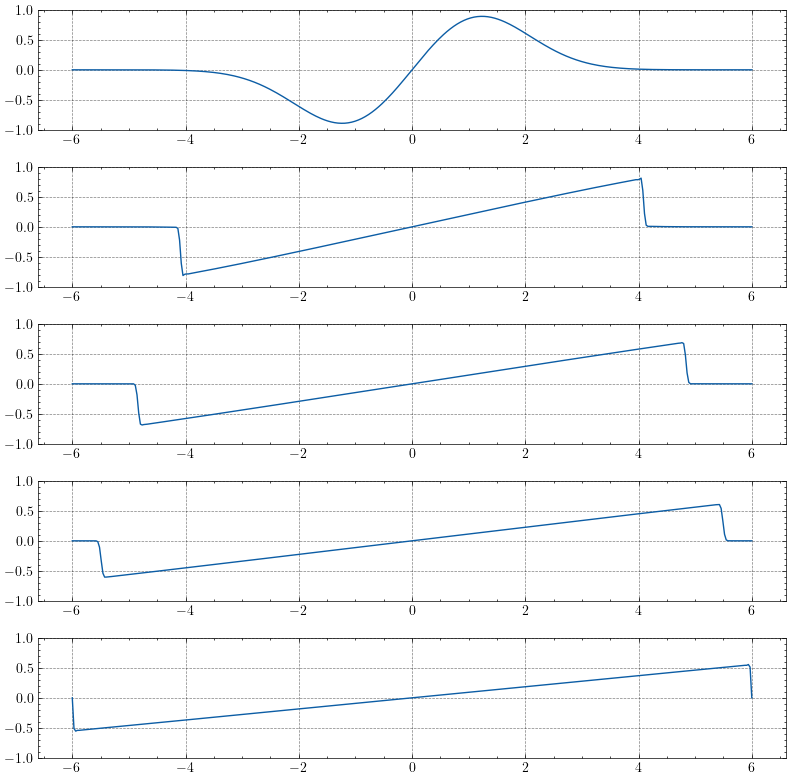

In [6]:
u_observed = u_strue[temporal_measurement_indices][:, spatial_measurement_indices] + np.random.normal(0, sigma_n_true, (temporal_points, spatial_points))

fig, axes = plt.subplots(5, 1, figsize=(8,8))
ymin = -1.
ymax = 1.
axes[0].plot(true_coordinates.flatten(),u_strue[1])
axes[0].set_ylim(ymin, ymax)
axes[1].plot(true_coordinates.flatten(),u_strue[int(np.floor(2*number_of_steps/5))])
axes[1].set_ylim(ymin, ymax)
axes[2].plot(true_coordinates.flatten(),u_strue[int(np.floor(3*number_of_steps/5))])
axes[2].set_ylim(ymin, ymax)
axes[3].plot(true_coordinates.flatten(),u_strue[int(np.floor(4*number_of_steps/5))])
axes[3].set_ylim(ymin, ymax)
axes[4].plot(true_coordinates.flatten(),u_strue[int(np.floor(5*number_of_steps/5 - 1))])
axes[4].set_ylim(ymin, ymax)
fig.tight_layout()
plt.show()

In [7]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 400

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = -6.
x_axis_right_boundary = 6.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.02
t_end = 5.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

newton_tol = 0.00001

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*coordinates).flatten()
#u_0 = np.exp((-(coordinates.flatten())**2)/2)
u_0 = np.exp(-((coordinates.flatten()-1)**2)/2) - np.exp(-((coordinates.flatten()+1)**2)/2) 
u_s = np.zeros((number_of_steps, n_x))
u_s[0,:] = u_0

u_guess = u_0 + np.random.normal(0, 0.001, len(u_0))
u_guess[0] = u_guess[-1] = 0

covs = [np.zeros((n_x, n_x))]

observation_operator = np.zeros((len(spatial_measurement_coordinates), len(coordinates)))
for i, y in enumerate(spatial_measurement_coordinates):
    nearest_index = np.argmin(np.abs(coordinates - y))
    observation_operator[i, nearest_index] = 1

def mark_times(all_time, mark_time):
    time_operator = np.zeros_like(all_time, dtype=bool)

    # Find the closest point in X for each element in Y
    for time in mark_time:
        closest_index = np.argmin(np.abs(all_time - time))
        time_operator[closest_index] = True
    return time_operator

time_operator = mark_times(time_range, temporal_measurement_coordinates)

In [8]:
# PRIORS ------------
# nu
# lower = 0.0001
# upper = 1.
# mu = 0.5
# sigma = 0.5
# nu_params = [lower, upper, mu, sigma]
lower = -3
upper = 1.
mu = -1.
sigma = 1.
nu_params = [lower, upper, mu, sigma]

# rho
lower = 0.0001
upper = 1.
mu = 0.5
sigma = 0.5
rho_params = [lower, upper, mu, sigma]

# ell
lower = 0.0001
upper = 3.
mu = 1.5
sigma = 1.5
ell_params = [lower, upper, mu, sigma]

# sigma_n
lower = 0.0001
upper = 0.1
mu = 0.5
sigma = 0.5
sigma_n_params = [lower, upper, mu, sigma]

# --------------



In [9]:
import pytensor.tensor as at
from pytensor import function, scan, shared, config, printing, graph
import numpy as np
from tqdm import tqdm
from pytensor import sparse

config.exception_verbosity = 'high'

K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

# CRANK NICHOLSON

@fem.BilinearForm
def A_build(u,v,w):
    return u*v

A_mat = A_build.assemble(basis).toarray()
A_mat[:,0] = A_mat[:,-1] = 0.
A_mat[0,:] = A_mat[-1,:] = 0.
A_mat[0,0] = 1e3
A_mat[-1,-1] = 1e3
# A_mat = scsparse.csr_matrix(A_mat)

@fem.BilinearForm
def B_build(u,v,w):
    return grad(u)[0]*v

B_mat = B_build.assemble(basis).toarray()
B_mat[:,0] = B_mat[:,-1] = 0.
B_mat[0,:] = B_mat[-1,:] = 0.
B_mat[0,0] = 1e3
B_mat[-1,-1] = 1e3
# B_mat = scsparse.csr_matrix(B_mat)

@fem.BilinearForm
def C_build(u,v,w):
    return dot(grad(u),grad(v))

C_mat = C_build.assemble(basis).toarray()
C_mat[:,0] = C_mat[:,-1] = 0.
C_mat[0,:] = C_mat[-1,:] = 0.
C_mat[0,0] = 1e3
C_mat[-1,-1] = 1e3
# C_mat = scsparse.csr_matrix(C_mat)

def residual_vector(dt, nu, u_sum, u_dif):
    return A_mat @ u_dif + (dt/4)*B_mat @ u_sum**2 + (dt*nu/2) * C_mat @ u_sum

def jacobian_matrix(dt, nu, u_sum):
    return A_mat + (dt/2)*B_mat @ u_sum + (dt*nu/2) * C_mat

def K_theta_mat(rho, ell, ktheta):
    G_vec = (rho**2)*tensor.math.exp(ktheta/(2*(ell**2)))
    #return M_mat @ tensor.reshape(G_vec, (n_x, n_x)) @ M_mat.T
    return tensor.reshape(G_vec, (n_x, n_x))

def K_theta_mat_np(rho, ell, ktheta):
    G_vec = (rho**2)*np.exp(ktheta/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))

K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

covs = np.zeros((number_of_steps, n_x, n_x))
jacobs = np.zeros((number_of_steps, n_x, n_x))

In [10]:
nu = nu_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

u_previous_test = u_0true
jac_previous_test = jacob
cov_previous_test = A_mat @ K_theta_mat_np(rho, ell, K_theta) @ A_mat.T
u_observed_test = u_observed[0,:]

with pm.Model() as model:
    nu = pm.TruncatedNormal('nu', mu=nu_params[2], sigma=nu_params[3], lower=nu_params[0], upper=nu_params[1])
    #nu = pm.Uniform('nu', lower=nu_params[0], upper=nu_params[1])
    rho = pm.TruncatedNormal('rho', mu=rho_params[2], sigma=rho_params[3], lower=rho_params[0], upper=rho_params[1])
    ell = pm.TruncatedNormal('ell', mu=ell_params[2], sigma=ell_params[3], lower=ell_params[0], upper=ell_params[1])
    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[2], sigma=sigma_n_params[3], lower=sigma_n_params[0], upper=sigma_n_params[1])
    
    dt_var = shared(dt)
    A_mat_var = shared(A_mat)
    B_mat_var = shared(B_mat)
    C_mat_var = shared(C_mat)
    u_prev_var = shared(u_previous_test)
    prev_jac = shared(jac_previous_test)
    prev_cov = shared(cov_previous_test)
    H_mat = shared(observation_operator)
    u_observed_var = shared(u_observed_test)
    K_theta_var = shared(K_theta)

    resid1 = at.dot(A_mat_var, u_prev_var - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (u_prev_var + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,u_prev_var + u_prev_var)
    jacob1 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, u_prev_var + u_prev_var) + (dt_var * (10**nu) / 2) * C_mat_var

    guess2 = u_prev_var + at.slinalg.solve(jacob1, -resid1)

    resid2 = at.dot(A_mat_var, guess2 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess2 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess2 + u_prev_var)
    jacob2 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess2 + u_prev_var) + (dt_var * (10**nu) / 2) * C_mat_var

    guess3 = guess2 + at.slinalg.solve(jacob2, -resid2)

    resid3 = at.dot(A_mat_var, guess3 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess3 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess3 + u_prev_var)
    jacob3 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess3 + u_prev_var) + (dt_var * (10**nu) / 2) * C_mat_var

    guess4 = guess3 + at.slinalg.solve(jacob3, -resid3)

    resid4 = at.dot(A_mat_var, guess4 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess4 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess4 + u_prev_var)
    jacob4 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess4 + u_prev_var) + (dt_var * (10**nu) / 2) * C_mat_var

    guess5 = guess4 + at.slinalg.solve(jacob4, -resid4)

    resid5 = at.dot(A_mat_var, guess5 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess5 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess5 + u_prev_var)
    jacob5 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess5 + u_prev_var) + (dt_var * (10**nu) / 2) * C_mat_var

    guess6 = guess5 + at.slinalg.solve(jacob5, -resid5)

    inv_jacob = at.linalg.inv(jacob5)

    cov_1 = at.dot(H_mat, at.dot(inv_jacob, at.dot(prev_jac, at.dot(prev_cov, at.dot(prev_jac, at.dot(inv_jacob.T, H_mat.T))))))
    cov_2 = dt * at.add(at.dot(H_mat, at.dot(inv_jacob, at.dot(A_mat, at.dot(K_theta_mat(rho, ell, K_theta_var), at.dot(A_mat.T, at.dot(inv_jacob.T, H_mat.T)))))), (sigma_n**2)*at.eye(spatial_points))
    pred_cov = at.add(cov_1, cov_2)

    y_obs = pm.MvNormal('y_obs', mu = H_mat @ guess6, cov = pred_cov, observed = u_observed_var)

In [12]:
with model:
    trace = pm.sample(100, tune=100, var_names=['nu', 'rho', 'ell', 'sigma_n'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, rho, ell, sigma_n]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 1269 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


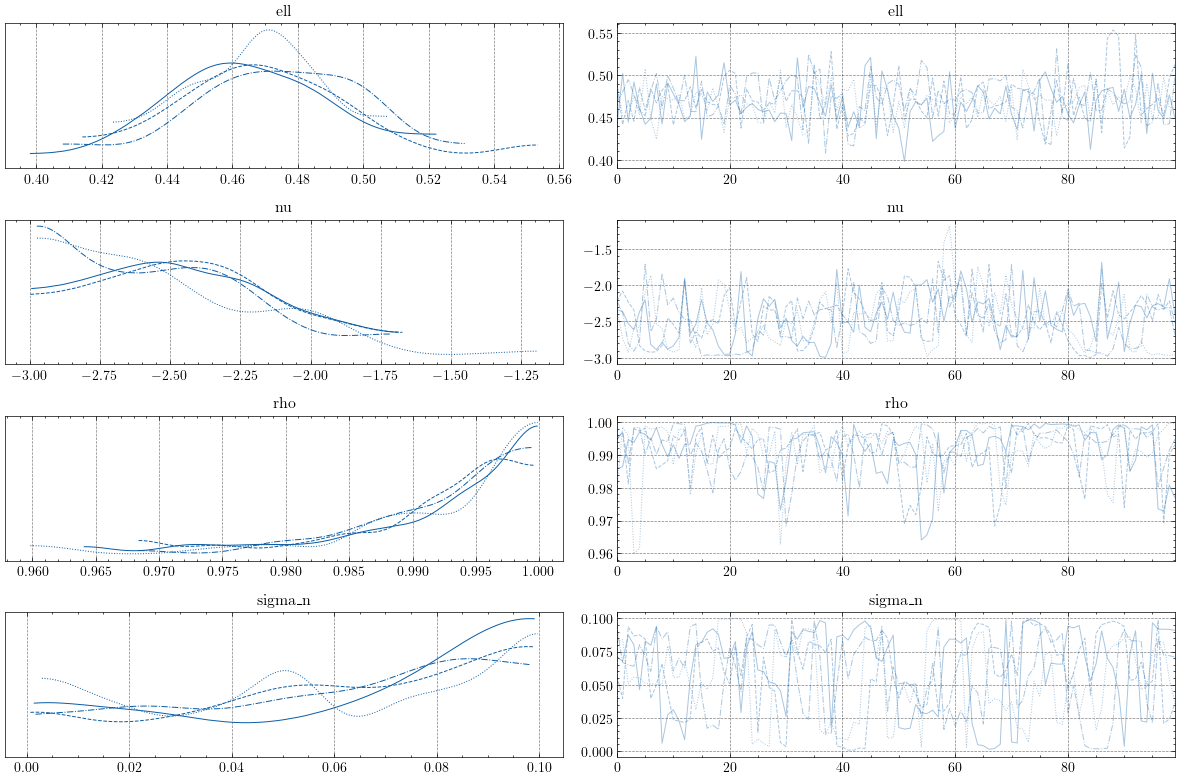

In [15]:
az.plot_trace(trace)
plt.tight_layout()

In [22]:
model_func = model.compile_logp()

In [16]:
printing.debugprint(model)

TypeError: debugprint cannot print an object type <class 'pymc.model.core.Model'>

In [45]:


# class SparseSolve(at.Op):
#     __props__ = ()

#     def make_node(self, A, b):
#         A = at.as_tensor_variable(A)
#         b = at.as_tensor_variable(b)
#         return graph.basic.Apply(self, [A, b], [b.type()])
    
#     def perform(self, node, inputs, outputs):
#         A, b = inputs
#         x = scsparse.linalg.spsolve(A, b)
#         outputs[0][0] = x

#     def infer_shape(self, fgraph, node, input_shapes):
#         return [input_shapes[1]]

# sparse_solve = SparseSolve()

# class SparseInverseApprox(at.Op):
#     __props__ = ()

#     def make_node(self, A):
#         A = at.as_tensor_variable(A)
#         return graph.basic.Apply(self, [A], [A.type()])

#     def perform(self, node, inputs, outputs):
#         A = inputs[0]
#         n = A.shape[0]
        
#         # Use the identity matrix as the right-hand side
#         I = scsparse.eye(n, format='csr')
        
#         # Solve AX = I
#         X = scsparse.linalg.spsolve(A, I)
        
#         outputs[0][0] = X

#     def infer_shape(self, fgraph, node, input_shapes):
#         return [input_shapes[0]]

#     def grad(self, inputs, output_grads):
#         # The gradient of matrix inverse is -A^(-1) * dZ * A^(-1)
#         A = inputs[0]
#         dZ = output_grads[0]
#         Ainv = self(A)
#         return [-at.dot(Ainv, at.dot(dZ, Ainv))]

# sparse_inverse_approx = SparseInverseApprox()

# dt_var = at.scalar('dt')  # Shared variable for dt
# nu_var = at.scalar('nu')  # Shared variable for nu
# sigma_n_var = at.scalar('sigma_n')
# rho_var = at.scalar('rho')
# ell_var = at.scalar('ell')
# u_prev_var = at.vector('u_prev')

# def get_next_guess(dt, nu, guess, u_prev, A_mat, B_mat, C_mat, n_x=n_x, return_jacob=False):
#     resid = at.dot(A_mat, guess - u_prev) + (dt / 4) * at.dot(B_mat, (guess + u_prev) ** 2) + (dt * nu / 2) * at.dot(C_mat,guess + u_prev)
#     jacob = A_mat + (dt/ 2) * at.dot(B_mat, guess + u_prev) + (dt * nu / 2) * C_mat
#     # jacob_sparse = sparse.csr_from_dense(jacob)
#     shift = at.slinalg.solve(jacob, -resid, check_finite=False, b_ndim=1)
#     # shift = sparse_solve(jacob_sparse, -resid)
#     if return_jacob == False:
#         return guess + shift
#     else:
#         return guess + shift, jacob

# def get_next_solution(nu, u_prev, dt=dt, A_mat=A_mat, B_mat=B_mat, C_mat=C_mat):
#     iter_1 = get_next_guess(dt, nu, u_prev, u_prev, A_mat, B_mat, C_mat)
#     iter_2 = get_next_guess(dt, nu, iter_1, u_prev, A_mat, B_mat, C_mat)
#     iter_3 = get_next_guess(dt, nu, iter_2, u_prev, A_mat, B_mat, C_mat)
#     iter_4 = get_next_guess(dt, nu, iter_3, u_prev, A_mat, B_mat, C_mat)
#     iter_5, jacob_5 = get_next_guess(dt, nu, iter_4, u_prev, A_mat, B_mat, C_mat, return_jacob=True)
#     return iter_5, jacob_5

# gns = get_next_solution(nu_var, u_prev_var)

# get_next_sol = function(inputs = [nu_var, u_prev_var], outputs=gns, profile=True)

traces = []

estimate = True

nu = nu_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

data_index = 0

for i in tqdm(range(number_of_steps-1)):
    u_previous = u_strue[i,:]
    if time_operator[i] == False:
        for j in range(5):
            u_sum = u_guess + u_previous
            u_dif = u_guess - u_previous
            resid = residual_vector(dt, 10**nu, u_sum, u_dif)
            jacob = jacobian_matrix(dt, 10**nu, u_sum)
            jacob_sparse = scsparse.csr_matrix(jacob)
            u_guess = u_guess + scsparse.linalg.spsolve(jacob_sparse, -resid)
        pred_mean = u_guess
        inv_jacob_sparse = scsparse.linalg.inv(jacob_sparse)
        jacob_dense = jacob_sparse.todense()
        inv_jacob_dense = inv_jacob_sparse.todense()
        cov_1 = inv_jacob_dense @ jacobs[-1] @ covs[-1] @ jacobs[-1] @ inv_jacob_dense.T
        cov_2 = dt * inv_jacob_dense @ A_mat @ K_theta_mat_np(rho, ell, K_theta) @ A_mat.T @ inv_jacob_dense.T
        pred_cov = cov_1 + cov_2
        covs[i, :, :] = pred_cov
        jacobs[i, :, :] = jacob_dense
        u_s[i+1, :] = pred_mean
    else:
        if estimate == False:
            for j in range(5):
                u_sum = u_guess + u_previous
                u_dif = u_guess - u_previous
                resid = residual_vector(dt, 10**nu, u_sum, u_dif)
                jacob = jacobian_matrix(dt, 10**nu, u_sum)
                jacob_sparse = scsparse.csr_matrix(jacob)
                u_guess = u_guess + scsparse.linalg.spsolve(jacob_sparse, -resid)
            pred_mean = u_guess
            inv_jacobs_sparse = scsparse.linalg.inv(jacob_sparse)
            jacob_dense = jacob_sparse.todense()
            inv_jacob_dense = inv_jacobs_sparse.todense()
            cov_1 = inv_jacob_dense @ jacobs[-1] @ covs[-1] @ jacobs[-1] @ inv_jacob_dense.T
            cov_2 = dt * inv_jacob_dense @ A_mat @ K_theta_mat_np(rho, ell, K_theta) @ A_mat.T @ inv_jacob_dense.T
            pred_cov = cov_1 + cov_2
            S_n = observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2) * np.eye(spatial_points)
            S_n_inverse = np.linalg.inv(S_n)
            updated_mean = pred_mean + pred_cov @ observation_operator.T @ S_n_inverse @ (u_observed[data_index,:] - observation_operator @ pred_mean)
            updated_cov = pred_cov - pred_cov @ observation_operator.T @ S_n_inverse @ observation_operator @ pred_cov
            covs[i, :, :] = updated_cov
            jacobs[i, :, :] = jacob_dense
            u_s[i+1, :] = updated_mean
            data_index += 1
        else:
            with pm.Model() as model:
                if data_index == 0:
                    nu = pm.TruncatedNormal('nu', mu=nu_params[2], sigma=nu_params[3], lower=nu_params[0], upper=nu_params[1])
                    #nu = pm.Uniform('nu', lower=nu_params[0], upper=nu_params[1])
                    rho = pm.TruncatedNormal('rho', mu=rho_params[2], sigma=rho_params[3], lower=rho_params[0], upper=rho_params[1])
                    ell = pm.TruncatedNormal('ell', mu=ell_params[2], sigma=ell_params[3], lower=ell_params[0], upper=ell_params[1])
                    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[2], sigma=sigma_n_params[3], lower=sigma_n_params[0], upper=sigma_n_params[1])
                else:
                    nu = pm.TruncatedNormal('nu', mu=nu, sigma=nu_std, lower=nu_updated_params[0], upper=nu_updated_params[1])
                    rho = pm.TruncatedNormal('rho', mu=rho, sigma=rho_std, lower=rho_updated_params[0], upper=rho_updated_params[1])
                    ell = pm.TruncatedNormal('ell', mu=ell, sigma=ell_std, lower=ell_updated_params[0], upper=ell_updated_params[1])
                    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n, sigma=sigma_n_std, lower=sigma_n_updated_params[0], upper=sigma_n_updated_params[1])
                    
                u_prev_var = shared(u_s[i,:])
                prev_jac = shared(jacobs[i,:,:])
                prev_cov = shared(covs[i,:,:])

                resid1 = at.dot(A_mat, u_prev_var - u_prev_var) + (dt / 4) * at.dot(B_mat, (u_prev_var + u_prev_var) ** 2) + (dt * (10**nu) / 2) * at.dot(C_mat,u_prev_var + u_prev_var)
                jacob1 = A_mat + (dt/ 2) * at.dot(B_mat, u_prev_var + u_prev_var) + (dt * (10**nu) / 2) * C_mat

                resid1_eval = resid1.eval()
                jacob1_eval = scsparse.csr_matrix(jacob1.eval())

                guess2 = u_prev_var + scsparse.linalg.spsolve(jacob1_eval, -resid1_eval)

                resid2 = at.dot(A_mat, guess2 - u_prev_var) + (dt / 4) * at.dot(B_mat, (guess2 + u_prev_var) ** 2) + (dt * (10**nu) / 2) * at.dot(C_mat,guess2 + u_prev_var)
                jacob2 = A_mat + (dt/ 2) * at.dot(B_mat, guess2 + u_prev_var) + (dt * (10**nu) / 2) * C_mat

                resid2_eval = resid2.eval()
                jacob2_eval = scsparse.csr_matrix(jacob2.eval())

                guess3 = guess2 + scsparse.linalg.spsolve(jacob2_eval, -resid2_eval)

                resid3 = at.dot(A_mat, guess3 - u_prev_var) + (dt / 4) * at.dot(B_mat, (guess3 + u_prev_var) ** 2) + (dt * (10**nu) / 2) * at.dot(C_mat,guess3 + u_prev_var)
                jacob3 = A_mat + (dt/ 2) * at.dot(B_mat, guess3 + u_prev_var) + (dt * (10**nu) / 2) * C_mat

                resid3_eval = resid3.eval()
                jacob3_eval = scsparse.csr_matrix(jacob3.eval())

                guess4 = guess3 + scsparse.linalg.spsolve(jacob3_eval, -resid3_eval)

                resid4 = at.dot(A_mat, guess4 - u_prev_var) + (dt / 4) * at.dot(B_mat, (guess4 + u_prev_var) ** 2) + (dt * (10**nu) / 2) * at.dot(C_mat,guess4 + u_prev_var)
                jacob4 = A_mat + (dt/ 2) * at.dot(B_mat, guess4 + u_prev_var) + (dt * (10**nu) / 2) * C_mat

                resid4_eval = resid4.eval()
                jacob4_eval = scsparse.csr_matrix(jacob4.eval())

                guess5 = guess4 + scsparse.linalg.spsolve(jacob4_eval, -resid4_eval)

                resid5 = at.dot(A_mat, guess5 - u_prev_var) + (dt / 4) * at.dot(B_mat, (guess5 + u_prev_var) ** 2) + (dt * (10**nu) / 2) * at.dot(C_mat,guess5 + u_prev_var)
                jacob5 = A_mat + (dt/ 2) * at.dot(B_mat, guess5 + u_prev_var) + (dt * (10**nu) / 2) * C_mat

                resid5_eval = resid5.eval()
                jacob5_eval = scsparse.csr_matrix(jacob5.eval())

                guess6 = guess5 + scsparse.linalg.spsolve(jacob5_eval, -resid5_eval)

                # pred_mean, jacob = get_next_solution(10**nu, u_prev_var)

                # inv_jacobs_sparse = sparse_inverse_approx(jacob_sparse)
                # jacob_dense = sparse.dense_from_sparse(jacob_sparse)
                # inv_jacob_dense = sparse.dense_from_sparse(inv_jacobs_sparse)

                inv_jacob = scsparse.linalg.inv(jacob5_eval).todense()

                cov_1 = at.dot(observation_operator, at.dot(inv_jacob, at.dot(prev_jac, at.dot(prev_cov, at.dot(prev_jac, at.dot(inv_jacob.T, observation_operator.T))))))
                cov_2 = dt * at.add(at.dot(observation_operator, at.dot(inv_jacob, at.dot(A_mat, at.dot(K_theta_mat(rho, ell, K_theta), at.dot(A_mat.T, at.dot(inv_jacob.T, observation_operator.T)))))), (sigma_n**2)*at.eye(spatial_points))
                pred_cov = at.add(cov_1, cov_2)

                y_obs = pm.MvNormal('y_obs', mu = observation_operator @ guess6, cov = pred_cov, observed = u_observed[data_index,:])
                trace = pm.sample(draws=300, tune=300, var_names=['nu','rho','ell','sigma_n'])

                traces.append(trace)

            # update parameters to means of their posteriors
            nu = np.mean(traces[-1].posterior['nu'].data.flatten())
            nu_std = np.std(traces[-1].posterior['nu'].data.flatten())
            #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
            nu_updated_params = [nu_params[0], nu_params[1], nu, nu_std]

            rho = np.mean(traces[-1].posterior['rho'].data.flatten())
            rho_std = np.std(traces[-1].posterior['rho'].data.flatten())
            #rho_updated_params = [rho - 3*rho_std, rho + 3*rho_std, rho, rho_std]
            rho_updated_params = [rho_params[0], rho_params[1], rho, rho_std]

            ell = np.mean(traces[-1].posterior['ell'].data.flatten())
            ell_std = np.std(traces[-1].posterior['ell'].data.flatten())
            #ell_updated_params = [ell - 3*ell_std, ell + 3*ell_std, ell, ell_std]
            ell_updated_params = [ell_params[0], ell_params[1], ell, ell_std]

            sigma_n = np.mean(traces[-1].posterior['sigma_n'].data.flatten())
            sigma_n_std = np.std(traces[-1].posterior['sigma_n'].data.flatten())
            #sigma_n_updated_params = [sigma_n- 3*sigma_n_std, sigma_n + 3*sigma_n_std, sigma_n, sigma_n_std]
            sigma_n_updated_params = [sigma_n_params[0], sigma_n_params[1], sigma_n, sigma_n_std]
            
            for j in range(5):
                u_sum = u_guess + u_previous
                u_dif = u_guess - u_previous
                resid = residual_vector(dt, 10**nu, u_sum, u_dif)
                jacob = jacobian_matrix(dt, 10**nu, u_sum)
                jacob_sparse = scsparse.csr_matrix(jacob)
                u_guess = u_guess + scsparse.linalg.spsolve(jacob_sparse, -resid)
            pred_mean = u_guess
            inv_jacobs_sparse = scsparse.linalg.inv(jacob_sparse)
            jacob_dense = jacob_sparse.todense()
            inv_jacob_dense = inv_jacobs_sparse.todense()
            cov_1 = inv_jacob_dense @ jacobs[-1] @ covs[-1] @ jacobs[-1] @ inv_jacob_dense.T
            cov_2 = dt * inv_jacob_dense @ A_mat @ K_theta_mat_np(rho, ell, K_theta) @ A_mat.T @ inv_jacob_dense.T
            pred_cov = cov_1 + cov_2
            S_n = observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2) * np.eye(spatial_points)
            S_n_inverse = np.linalg.inv(S_n)
            updated_mean = pred_mean + pred_cov @ observation_operator.T @ S_n_inverse @ (u_observed[data_index,:] - observation_operator @ pred_mean)
            updated_cov = pred_cov - pred_cov @ observation_operator.T @ S_n_inverse @ observation_operator @ pred_cov
            covs[i, :, :] = updated_cov
            jacobs[i, :, :] = jacob_dense
            u_s[i+1, :] = updated_mean
            data_index += 1



  0%|          | 0/249 [00:00<?, ?it/s]

/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)
 33%|███▎      | 83/249 [00:17<00:30,  5.50it/s]/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess s

Output()

Sampling 4 chains for 300 tune and 300 draw iterations (1_200 + 1_200 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)
 67%|██████▋   | 166/249 [03:14<00:16,  4.90it/s] /home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site

Output()

Sampling 4 chains for 300 tune and 300 draw iterations (1_200 + 1_200 draws total) took 112 seconds.
/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)
100%|██████████| 249/249 [05:38<00:00,  1.36s/it]


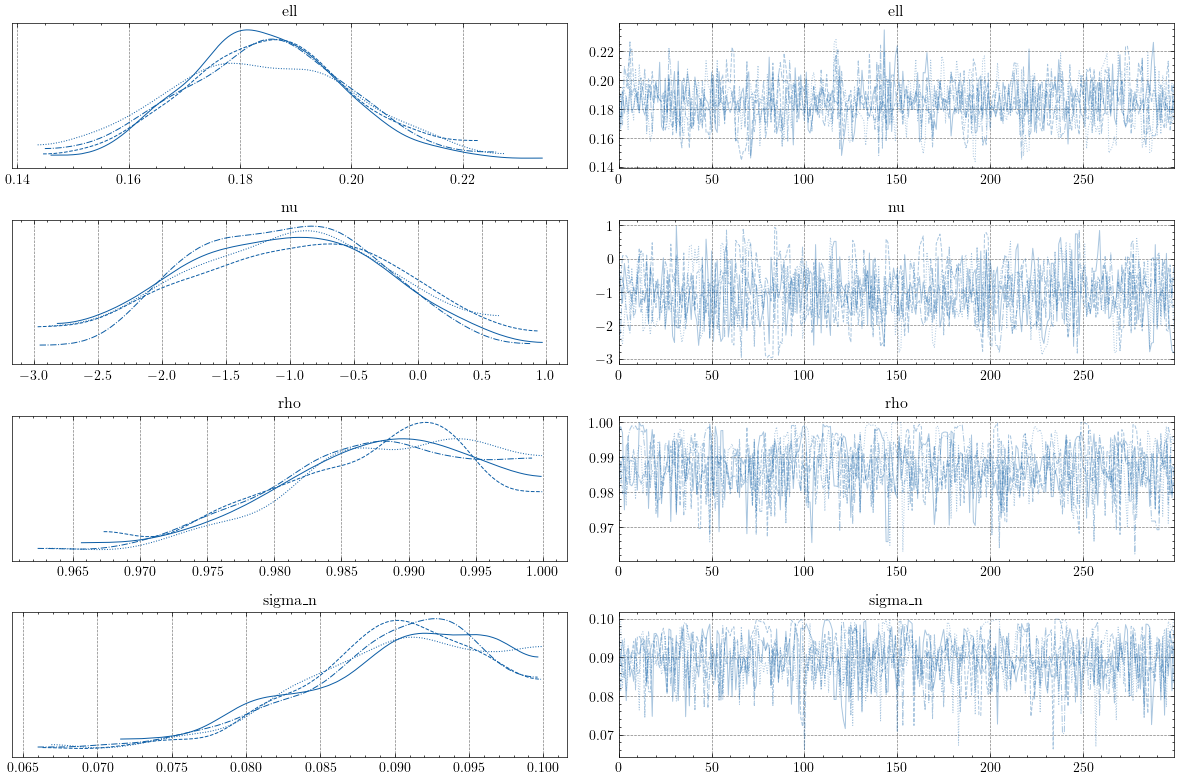

In [33]:
az.plot_trace(traces[1])
plt.tight_layout()

/tmp/ipykernel_344326/2367957933.py:10: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])) - 2*np.mean(sigma_n_estimates[-1]), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.3, color=color_list[5], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
/tmp/ipykernel_344326/2367957933.py:11: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])) + 2*np.mean(sigma_n_estimates[-1]), alpha=0.3, col

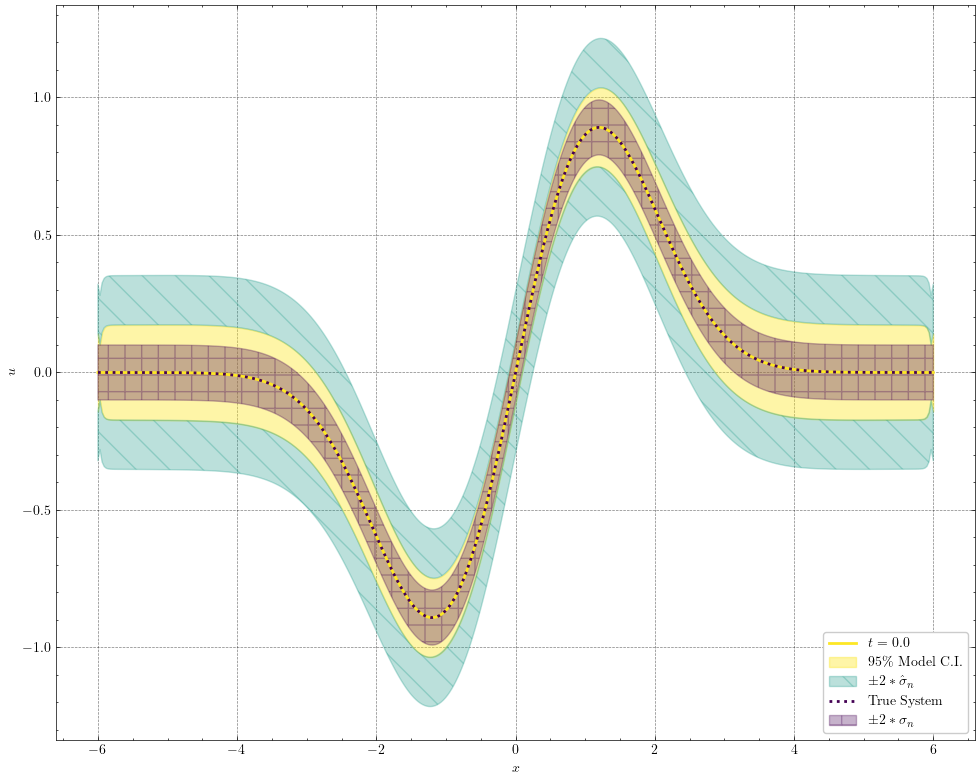

In [36]:
sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]

time_index = 0
time_labels = [r"$t=$ "+str(time_range[i]) for i in range(len(time_range))]

fig, axes = plt.subplots(figsize=(10,8))

axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[0], linewidth=2.)
axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.4, color=color_list[0], label=r'$95\%$ Model C.I.')
axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])) - 2*np.mean(sigma_n_estimates[-1]), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.3, color=color_list[5], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])) + 2*np.mean(sigma_n_estimates[-1]), alpha=0.3, color=color_list[5], hatch=r"\ ")

axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted', linewidth=2.)
axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$u$')

axes.legend(loc='lower right')
fig.tight_layout()

In [21]:
jacob_sparse

SparseVariable{csr,float64}

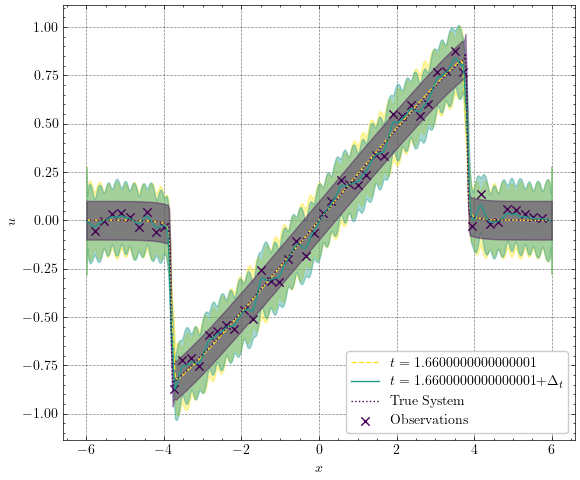

In [13]:
interest = 0
time_labels = [r"$t=$ "+str(temporal_measurement_coordinates[i]) for i in range(len(temporal_measurement_coordinates))]
plot_ind = temporal_measurement_indices[interest]

fig, axes = plt.subplots(figsize=(6,5))

axes.plot(coordinates,u_s[plot_ind,:], label=time_labels[interest], color=color_list[0], linestyle='dashed')
axes.fill_between(coordinates.flatten(), u_s[plot_ind,:] - 2*np.sqrt(np.diag(covs[plot_ind,:,:])), u_s[plot_ind,:] + 2*np.sqrt(np.diag(covs[plot_ind,:,:])), alpha=0.4, color=color_list[0])

axes.plot(coordinates,u_s[plot_ind + 1,:], label=time_labels[interest] + r'$+ \Delta_t$', color=color_list[5])
axes.fill_between(coordinates.flatten(), u_s[plot_ind+1,:] - 2*np.sqrt(np.diag(covs[plot_ind,:,:])), u_s[plot_ind+1,:] + 2*np.sqrt(np.diag(covs[plot_ind,:,:])), alpha=0.4, color=color_list[5])

axes.plot(true_coordinates, u_strue[plot_ind+1,:], label='True System', color=color_list[11], linestyle='dotted')
axes.scatter(spatial_measurement_coordinates, u_observed[interest,:], label='Observations', marker='x', color=color_list[11])
axes.fill_between(true_coordinates.flatten(), u_strue[plot_ind+1,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[plot_ind+1,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.4, color=color_list[11])

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$u$')

axes.legend(loc='lower right')
fig.tight_layout()
plt.show()

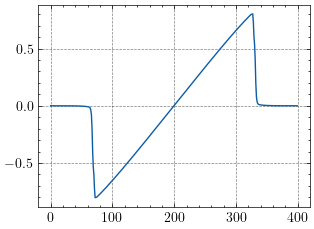

In [18]:
plt.plot(u_s[91,:])

In [97]:
import pytensor.tensor as at
from pytensor import function, scan, shared, config, printing, graph
import numpy as np
from tqdm import tqdm
from pytensor import sparse

config.exception_verbosity = 'high'

K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

class SparseSolve(at.Op):
    __props__ = ()

    def make_node(self, A, b):
        A = at.as_tensor_variable(A)
        b = at.as_tensor_variable(b)
        return graph.basic.Apply(self, [A, b], [b.type()])
    
    def perform(self, node, inputs, outputs):
        A, b = inputs
        x = scsparse.linalg.spsolve(A, b)
        outputs[0][0] = x

    def infer_shape(self, fgraph, node, input_shapes):
        return [input_shapes[1]]

sparse_solve = SparseSolve()

class SparseInverseApprox(at.Op):
    __props__ = ()

    def make_node(self, A):
        A = at.as_tensor_variable(A)
        return graph.basic.Apply(self, [A], [A.type()])

    def perform(self, node, inputs, outputs):
        A = inputs[0]
        n = A.shape[0]
        
        # Use the identity matrix as the right-hand side
        I = scsparse.eye(n, format='csr')
        
        # Solve AX = I
        X = scsparse.linalg.spsolve(A, I)
        
        outputs[0][0] = X

    def infer_shape(self, fgraph, node, input_shapes):
        return [input_shapes[0]]

    def grad(self, inputs, output_grads):
        # The gradient of matrix inverse is -A^(-1) * dZ * A^(-1)
        A = inputs[0]
        dZ = output_grads[0]
        Ainv = self(A)
        return [-at.dot(Ainv, at.dot(dZ, Ainv))]

sparse_inverse_approx = SparseInverseApprox()

dt_var = at.scalar('dt')  # Shared variable for dt
nu_var = at.scalar('nu')  # Shared variable for nu
sigma_n_var = at.scalar('sigma_n')
rho_var = at.scalar('rho')
ell_var = at.scalar('ell')
u_prev_var = at.vector('u_prev')

def get_next_guess(dt, nu, guess, u_prev, A_mat, B_mat, C_mat, n_x=n_x, return_jacob=False):
    resid = at.dot(A_mat, guess - u_prev) + (dt / 4) * at.dot(B_mat, (guess + u_prev) ** 2) + (dt * nu / 2) * at.dot(C_mat,guess + u_prev)
    jacob = A_mat + (dt/ 2) * at.dot(B_mat, guess + u_prev) + (dt * nu / 2) * C_mat
    jacob_sparse = sparse.csr_from_dense(jacob)
    # shift = at.slinalg.solve(jacob_sparse, -resid, check_finite=False, b_ndim=1)
    shift = sparse_solve(jacob_sparse, -resid)
    if return_jacob == False:
        return guess + shift
    else:
        return guess + shift, jacob_sparse
    
def get_next_solution(dt, nu, u_prev, A_mat=A_mat, B_mat=B_mat, C_mat=C_mat):
    iter_1 = get_next_guess(dt, nu, u_prev, u_prev, A_mat, B_mat, C_mat)
    iter_2 = get_next_guess(dt, nu, iter_1, u_prev, A_mat, B_mat, C_mat)
    iter_3 = get_next_guess(dt, nu, iter_2, u_prev, A_mat, B_mat, C_mat)
    iter_4 = get_next_guess(dt, nu, iter_3, u_prev, A_mat, B_mat, C_mat)
    iter_5, jacob_5 = get_next_guess(dt, nu, iter_4, u_prev, A_mat, B_mat, C_mat, return_jacob=True)
    return iter_5, jacob_5

gns = get_next_solution(dt_var, nu_var, u_prev_var)

get_next_sol = function(inputs = [dt_var, nu_var, u_prev_var], outputs=gns, profile=True)


# def get_mean_and_cov(nu, rho, ell, sigma_n, u_prev, dt, H_mat = at.as_tensor(observation_operator), k_theta = at.as_tensor(K_theta), prev_jacob=at.zeros((n_x, n_x)), prev_cov=at.zeros((n_x, n_x)), A_mat = A_mat, n_x = n_x, n_y=spatial_points):
#     mean_state_u, jacobian_u = get_next_solution(dt, nu, u_prev)
#     mu_u = at.dot(H_mat, mean_state_u)
#     inverse_jacobian_u_sparse = sparse_inverse_approx(jacobian_u)
#     inverse_jacobian_u = sparse.dense_from_sparse(inverse_jacobian_u_sparse)
#     cov_1 = at.dot(H_mat, at.dot(inverse_jacobian_u , at.dot(prev_jacob , at.dot(prev_cov , at.dot(prev_jacob.T ,at.dot(inverse_jacobian_u.T, H_mat.T))))))
#     G_vec = (rho**2)*at.math.exp(k_theta/(2*(ell**2)))
#     G_vec_reshape = at.reshape(G_vec, (n_x, n_x))
#     cov_2 = dt * at.dot(H_mat, at.dot(inverse_jacobian_u, at.dot(A_mat, at.dot(G_vec_reshape, at.dot(A_mat.T, at.dot(inverse_jacobian_u.T, H_mat.T)))))) + (sigma_n**2)*at.eye(n_y)
#     return mu_u, cov_1 + cov_2




# gnl = get_mean_and_cov(nu_var, rho_var, ell_var, sigma_n_var, u_prev_var, dt_var)

# get_next_likelihood = function(inputs = [nu_var, rho_var, ell_var, sigma_n_var, u_prev_var, dt_var], outputs=gnl, profile=True)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Assert{msg='PyTensor Assert failed!'}(0.0, False)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1912, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1081, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/pytensor/tensor/rewriting/basic.py", line 1122, in constant_folding
    required = thunk()
               ^^^^^^^
  File "/home/danielclaassen/anaconda

AssertionError: PyTensor Assert failed!

In [92]:
get_next_likelihood(0.01, 0.1, 1., 0.01, u_0true, dt)

ValueError: Shape mismatch: A.shape[1] != x.shape[0]
Apply node that caused the error: CGemv{inplace}(AllocEmpty{dtype='float64'}.0, 1.0, [[0. 0. 0. ... 0. 0. 0.]], Add.0, 0.0)
Toposort index: 84
Inputs types: [TensorType(float64, shape=(52,)), TensorType(float64, shape=()), TensorType(float64, shape=(52, 200)), TensorType(float64, shape=(400,)), TensorType(float64, shape=())]
Inputs shapes: [(52,), (), (52, 200), (400,), ()]
Inputs strides: [(8,), (), (1600, 8), (8,), ()]
Inputs values: ['not shown', array(1.), 'not shown', 'not shown', array(0.)]
Inputs type_num: [12, 12, 12, 12, 12]
Outputs clients: [[output[0](CGemv{inplace}.0)]]

Debug print of the apply node: 
CGemv{inplace} [id A] <Vector(float64, shape=(52,))>
 ├─ AllocEmpty{dtype='float64'} [id B] <Vector(float64, shape=(52,))>
 │  └─ 52 [id C] <Scalar(int64, shape=())>
 ├─ 1.0 [id D] <Scalar(float64, shape=())>
 ├─ [[0. 0. 0. ... 0. 0. 0.]] [id E] <Matrix(float64, shape=(52, 200))>
 ├─ Add [id F] <Vector(float64, shape=(400,))>
 │  ├─ u_prev [id G] <Vector(float64, shape=(?,))>
 │  ├─ SparseSolve [id H] <Vector(float64, shape=(400,))>
 │  │  ├─ SparseFromDense{csr} [id I] <SparseTensorType{dtype='float64', format='csr', shape=(None, None)}>
 │  │  │  └─ Composite{...}.0 [id J] <Matrix(float64, shape=(400, 400))>
 │  │  │     ├─ ExpandDims{axes=[0, 1]} [id K] <Matrix(float64, shape=(1, 1))>
 │  │  │     │  └─ dt [id L] <Scalar(float64, shape=())>
 │  │  │     ├─ ExpandDims{axes=[0, 1]} [id M] <Matrix(float64, shape=(1, 1))>
 │  │  │     │  └─ nu [id N] <Scalar(float64, shape=())>
 │  │  │     ├─ [[1000. ... 1000.  ]] [id O] <Matrix(float64, shape=(400, 400))>
 │  │  │     ├─ [[1.000000 ... 0000e+03]] [id P] <Matrix(float64, shape=(400, 400))>
 │  │  │     └─ Mul [id Q] <Matrix(float64, shape=(1, 400))>
 │  │  │        ├─ [[0.5]] [id R] <Matrix(float64, shape=(1, 1))>
 │  │  │        ├─ ExpandDims{axes=[0, 1]} [id K] <Matrix(float64, shape=(1, 1))>
 │  │  │        │  └─ ···
 │  │  │        └─ ExpandDims{axis=0} [id S] <Matrix(float64, shape=(1, 400))>
 │  │  │           └─ CGemv{inplace} [id T] <Vector(float64, shape=(400,))>
 │  │  │              ├─ AllocEmpty{dtype='float64'} [id U] <Vector(float64, shape=(400,))>
 │  │  │              │  └─ 400 [id V] <Scalar(int64, shape=())>
 │  │  │              ├─ 1.0 [id D] <Scalar(float64, shape=())>
 │  │  │              ├─ [[ 1.00000 ... 0000e+03]] [id W] <Matrix(float64, shape=(400, 400))>
 │  │  │              ├─ Composite{...}.0 [id X] <Vector(float64, shape=(?,))>
 │  │  │              │  └─ u_prev [id G] <Vector(float64, shape=(?,))>
 │  │  │              └─ 0.0 [id Y] <Scalar(float64, shape=())>
 │  │  └─ CGemv{inplace} [id Z] <Vector(float64, shape=(400,))>
 │  │     ├─ CGemv{inplace} [id BA] <Vector(float64, shape=(400,))>
 │  │     │  ├─ CGemv{inplace} [id BB] <Vector(float64, shape=(400,))>
 │  │     │  │  ├─ AllocEmpty{dtype='float64'} [id BC] <Vector(float64, shape=(400,))>
 │  │     │  │  │  └─ 400 [id V] <Scalar(int64, shape=())>
 │  │     │  │  ├─ 1.0 [id D] <Scalar(float64, shape=())>
 │  │     │  │  ├─ [[1.000000 ... 0000e+03]] [id P] <Matrix(float64, shape=(400, 400))>
 │  │     │  │  ├─ Alloc [id BD] <Vector(float64, shape=(?,))>
 │  │     │  │  │  ├─ [0.] [id BE] <Vector(float64, shape=(1,))>
 │  │     │  │  │  └─ Shape_i{0} [id BF] <Scalar(int64, shape=())>
 │  │     │  │  │     └─ u_prev [id G] <Vector(float64, shape=(?,))>
 │  │     │  │  └─ 0.0 [id Y] <Scalar(float64, shape=())>
 │  │     │  ├─ Mul [id BG] <Scalar(float64, shape=())>
 │  │     │  │  ├─ -0.25 [id BH] <Scalar(float64, shape=())>
 │  │     │  │  └─ dt [id L] <Scalar(float64, shape=())>
 │  │     │  ├─ [[ 1.00000 ... 0000e+03]] [id W] <Matrix(float64, shape=(400, 400))>
 │  │     │  ├─ Composite{...}.1 [id X] <Vector(float64, shape=(?,))>
 │  │     │  │  └─ ···
 │  │     │  └─ -1.0 [id BI] <Scalar(float64, shape=())>
 │  │     ├─ Mul [id BJ] <Scalar(float64, shape=())>
 │  │     │  ├─ -0.5 [id BK] <Scalar(float64, shape=())>
 │  │     │  ├─ dt [id L] <Scalar(float64, shape=())>
 │  │     │  └─ nu [id N] <Scalar(float64, shape=())>
 │  │     ├─ [[1000. ... 1000.  ]] [id O] <Matrix(float64, shape=(400, 400))>
 │  │     ├─ Composite{...}.0 [id X] <Vector(float64, shape=(?,))>
 │  │     │  └─ ···
 │  │     └─ 1.0 [id D] <Scalar(float64, shape=())>
 │  ├─ SparseSolve [id BL] <Vector(float64, shape=(400,))>
 │  │  ├─ SparseFromDense{csr} [id BM] <SparseTensorType{dtype='float64', format='csr', shape=(None, None)}>
 │  │  │  └─ Add [id BN] <Matrix(float64, shape=(400, 400))>
 │  │  │     ├─ [[1.000000 ... 0000e+03]] [id P] <Matrix(float64, shape=(400, 400))>
 │  │  │     ├─ Mul [id BO] <Matrix(float64, shape=(1, 400))>
 │  │  │     │  ├─ [[0.5]] [id R] <Matrix(float64, shape=(1, 1))>
 │  │  │     │  ├─ ExpandDims{axes=[0, 1]} [id K] <Matrix(float64, shape=(1, 1))>
 │  │  │     │  │  └─ ···
 │  │  │     │  └─ ExpandDims{axis=0} [id BP] <Matrix(float64, shape=(1, 400))>
 │  │  │     │     └─ CGemv{inplace} [id BQ] <Vector(float64, shape=(400,))>
 │  │  │     │        ├─ AllocEmpty{dtype='float64'} [id BR] <Vector(float64, shape=(400,))>
 │  │  │     │        │  └─ 400 [id V] <Scalar(int64, shape=())>
 │  │  │     │        ├─ 1.0 [id D] <Scalar(float64, shape=())>
 │  │  │     │        ├─ [[ 1.00000 ... 0000e+03]] [id W] <Matrix(float64, shape=(400, 400))>
 │  │  │     │        ├─ Composite{...}.0 [id BS] <Vector(float64, shape=(400,))>
 │  │  │     │        │  ├─ u_prev [id G] <Vector(float64, shape=(?,))>
 │  │  │     │        │  └─ SparseSolve [id H] <Vector(float64, shape=(400,))>
 │  │  │     │        │     └─ ···
 │  │  │     │        └─ 0.0 [id Y] <Scalar(float64, shape=())>
 │  │  │     └─ Composite{...}.1 [id J] <Matrix(float64, shape=(400, 400))>
 │  │  │        └─ ···
 │  │  └─ CGemv{inplace} [id BT] <Vector(float64, shape=(400,))>
 │  │     ├─ CGemv{inplace} [id BU] <Vector(float64, shape=(400,))>
 │  │     │  ├─ CGemv{inplace} [id BV] <Vector(float64, shape=(400,))>
 │  │     │  │  ├─ AllocEmpty{dtype='float64'} [id BW] <Vector(float64, shape=(400,))>
 │  │     │  │  │  └─ 400 [id V] <Scalar(int64, shape=())>
 │  │     │  │  ├─ 1.0 [id D] <Scalar(float64, shape=())>
 │  │     │  │  ├─ [[1.000000 ... 0000e+03]] [id P] <Matrix(float64, shape=(400, 400))>
 │  │     │  │  ├─ SparseSolve [id H] <Vector(float64, shape=(400,))>
 │  │     │  │  │  └─ ···
 │  │     │  │  └─ 0.0 [id Y] <Scalar(float64, shape=())>
 │  │     │  ├─ Mul [id BG] <Scalar(float64, shape=())>
 │  │     │  │  └─ ···
 │  │     │  ├─ [[ 1.00000 ... 0000e+03]] [id W] <Matrix(float64, shape=(400, 400))>
 │  │     │  ├─ Composite{...}.1 [id BS] <Vector(float64, shape=(400,))>
 │  │     │  │  └─ ···
 │  │     │  └─ -1.0 [id BI] <Scalar(float64, shape=())>
 │  │     ├─ Mul [id BJ] <Scalar(float64, shape=())>
 │  │     │  └─ ···
 │  │     ├─ [[1000. ... 1000.  ]] [id O] <Matrix(float64, shape=(400, 400))>
 │  │     ├─ Composite{...}.0 [id BS] <Vector(float64, shape=(400,))>
 │  │     │  └─ ···
 │  │     └─ 1.0 [id D] <Scalar(float64, shape=())>
 │  ├─ SparseSolve [id BX] <Vector(float64, shape=(400,))>
 │  │  ├─ SparseFromDense{csr} [id BY] <SparseTensorType{dtype='float64', format='csr', shape=(None, None)}>
 │  │  │  └─ Add [id BZ] <Matrix(float64, shape=(400, 400))>
 │  │  │     ├─ [[1.000000 ... 0000e+03]] [id P] <Matrix(float64, shape=(400, 400))>
 │  │  │     ├─ Mul [id CA] <Matrix(float64, shape=(1, 400))>
 │  │  │     │  ├─ [[0.5]] [id R] <Matrix(float64, shape=(1, 1))>
 │  │  │     │  ├─ ExpandDims{axes=[0, 1]} [id K] <Matrix(float64, shape=(1, 1))>
 │  │  │     │  │  └─ ···
 │  │  │     │  └─ ExpandDims{axis=0} [id CB] <Matrix(float64, shape=(1, 400))>
 │  │  │     │     └─ CGemv{inplace} [id CC] <Vector(float64, shape=(400,))>
 │  │  │     │        ├─ AllocEmpty{dtype='float64'} [id CD] <Vector(float64, shape=(400,))>
 │  │  │     │        │  └─ 400 [id V] <Scalar(int64, shape=())>
 │  │  │     │        ├─ 1.0 [id D] <Scalar(float64, shape=())>
 │  │  │     │        ├─ [[ 1.00000 ... 0000e+03]] [id W] <Matrix(float64, shape=(400, 400))>
 │  │  │     │        ├─ Composite{...}.0 [id CE] <Vector(float64, shape=(400,))>
 │  │  │     │        │  ├─ u_prev [id G] <Vector(float64, shape=(?,))>
 │  │  │     │        │  ├─ SparseSolve [id H] <Vector(float64, shape=(400,))>
 │  │  │     │        │  │  └─ ···
 │  │  │     │        │  └─ SparseSolve [id BL] <Vector(float64, shape=(400,))>
 │  │  │     │        │     └─ ···
 │  │  │     │        └─ 0.0 [id Y] <Scalar(float64, shape=())>
 │  │  │     └─ Composite{...}.1 [id J] <Matrix(float64, shape=(400, 400))>
 │  │  │        └─ ···
 │  │  └─ CGemv{inplace} [id CF] <Vector(float64, shape=(400,))>
 │  │     ├─ CGemv{inplace} [id CG] <Vector(float64, shape=(400,))>
 │  │     │  ├─ CGemv{inplace} [id CH] <Vector(float64, shape=(400,))>
 │  │     │  │  ├─ AllocEmpty{dtype='float64'} [id CI] <Vector(float64, shape=(400,))>
 │  │     │  │  │  └─ 400 [id V] <Scalar(int64, shape=())>
 │  │     │  │  ├─ 1.0 [id D] <Scalar(float64, shape=())>
 │  │     │  │  ├─ [[1.000000 ... 0000e+03]] [id P] <Matrix(float64, shape=(400, 400))>
 │  │     │  │  ├─ Add [id CJ] <Vector(float64, shape=(400,))>
 │  │     │  │  │  ├─ SparseSolve [id H] <Vector(float64, shape=(400,))>
 │  │     │  │  │  │  └─ ···
 │  │     │  │  │  └─ SparseSolve [id BL] <Vector(float64, shape=(400,))>
 │  │     │  │  │     └─ ···
 │  │     │  │  └─ 0.0 [id Y] <Scalar(float64, shape=())>
 │  │     │  ├─ Mul [id BG] <Scalar(float64, shape=())>
 │  │     │  │  └─ ···
 │  │     │  ├─ [[ 1.00000 ... 0000e+03]] [id W] <Matrix(float64, shape=(400, 400))>
 │  │     │  ├─ Composite{...}.1 [id CE] <Vector(float64, shape=(400,))>
 │  │     │  │  └─ ···
 │  │     │  └─ -1.0 [id BI] <Scalar(float64, shape=())>
 │  │     ├─ Mul [id BJ] <Scalar(float64, shape=())>
 │  │     │  └─ ···
 │  │     ├─ [[1000. ... 1000.  ]] [id O] <Matrix(float64, shape=(400, 400))>
 │  │     ├─ Composite{...}.0 [id CE] <Vector(float64, shape=(400,))>
 │  │     │  └─ ···
 │  │     └─ 1.0 [id D] <Scalar(float64, shape=())>
 │  ├─ SparseSolve [id CK] <Vector(float64, shape=(400,))>
 │  │  ├─ SparseFromDense{csr} [id CL] <SparseTensorType{dtype='float64', format='csr', shape=(None, None)}>
 │  │  │  └─ Add [id CM] <Matrix(float64, shape=(400, 400))>
 │  │  │     ├─ [[1.000000 ... 0000e+03]] [id P] <Matrix(float64, shape=(400, 400))>
 │  │  │     ├─ Mul [id CN] <Matrix(float64, shape=(1, 400))>
 │  │  │     │  ├─ [[0.5]] [id R] <Matrix(float64, shape=(1, 1))>
 │  │  │     │  ├─ ExpandDims{axes=[0, 1]} [id K] <Matrix(float64, shape=(1, 1))>
 │  │  │     │  │  └─ ···
 │  │  │     │  └─ ExpandDims{axis=0} [id CO] <Matrix(float64, shape=(1, 400))>
 │  │  │     │     └─ CGemv{inplace} [id CP] <Vector(float64, shape=(400,))>
 │  │  │     │        ├─ AllocEmpty{dtype='float64'} [id CQ] <Vector(float64, shape=(400,))>
 │  │  │     │        │  └─ 400 [id V] <Scalar(int64, shape=())>
 │  │  │     │        ├─ 1.0 [id D] <Scalar(float64, shape=())>
 │  │  │     │        ├─ [[ 1.00000 ... 0000e+03]] [id W] <Matrix(float64, shape=(400, 400))>
 │  │  │     │        ├─ Composite{...}.0 [id CR] <Vector(float64, shape=(400,))>
 │  │  │     │        │  ├─ u_prev [id G] <Vector(float64, shape=(?,))>
 │  │  │     │        │  ├─ SparseSolve [id H] <Vector(float64, shape=(400,))>
 │  │  │     │        │  │  └─ ···
 │  │  │     │        │  ├─ SparseSolve [id BL] <Vector(float64, shape=(400,))>
 │  │  │     │        │  │  └─ ···
 │  │  │     │        │  └─ SparseSolve [id BX] <Vector(float64, shape=(400,))>
 │  │  │     │        │     └─ ···
 │  │  │     │        └─ 0.0 [id Y] <Scalar(float64, shape=())>
 │  │  │     └─ Composite{...}.1 [id J] <Matrix(float64, shape=(400, 400))>
 │  │  │        └─ ···
 │  │  └─ CGemv{inplace} [id CS] <Vector(float64, shape=(400,))>
 │  │     ├─ CGemv{inplace} [id CT] <Vector(float64, shape=(400,))>
 │  │     │  ├─ CGemv{inplace} [id CU] <Vector(float64, shape=(400,))>
 │  │     │  │  ├─ AllocEmpty{dtype='float64'} [id CV] <Vector(float64, shape=(400,))>
 │  │     │  │  │  └─ 400 [id V] <Scalar(int64, shape=())>
 │  │     │  │  ├─ 1.0 [id D] <Scalar(float64, shape=())>
 │  │     │  │  ├─ [[1.000000 ... 0000e+03]] [id P] <Matrix(float64, shape=(400, 400))>
 │  │     │  │  ├─ Add [id CW] <Vector(float64, shape=(400,))>
 │  │     │  │  │  ├─ SparseSolve [id H] <Vector(float64, shape=(400,))>
 │  │     │  │  │  │  └─ ···
 │  │     │  │  │  ├─ SparseSolve [id BL] <Vector(float64, shape=(400,))>
 │  │     │  │  │  │  └─ ···
 │  │     │  │  │  └─ SparseSolve [id BX] <Vector(float64, shape=(400,))>
 │  │     │  │  │     └─ ···
 │  │     │  │  └─ 0.0 [id Y] <Scalar(float64, shape=())>
 │  │     │  ├─ Mul [id BG] <Scalar(float64, shape=())>
 │  │     │  │  └─ ···
 │  │     │  ├─ [[ 1.00000 ... 0000e+03]] [id W] <Matrix(float64, shape=(400, 400))>
 │  │     │  ├─ Composite{...}.1 [id CR] <Vector(float64, shape=(400,))>
 │  │     │  │  └─ ···
 │  │     │  └─ -1.0 [id BI] <Scalar(float64, shape=())>
 │  │     ├─ Mul [id BJ] <Scalar(float64, shape=())>
 │  │     │  └─ ···
 │  │     ├─ [[1000. ... 1000.  ]] [id O] <Matrix(float64, shape=(400, 400))>
 │  │     ├─ Composite{...}.0 [id CR] <Vector(float64, shape=(400,))>
 │  │     │  └─ ···
 │  │     └─ 1.0 [id D] <Scalar(float64, shape=())>
 │  └─ SparseSolve [id CX] <Vector(float64, shape=(400,))>
 │     ├─ SparseFromDense{csr} [id CY] <SparseTensorType{dtype='float64', format='csr', shape=(None, None)}>
 │     │  └─ Add [id CZ] <Matrix(float64, shape=(400, 400))>
 │     │     ├─ [[1.000000 ... 0000e+03]] [id P] <Matrix(float64, shape=(400, 400))>
 │     │     ├─ Mul [id DA] <Matrix(float64, shape=(1, 400))>
 │     │     │  ├─ [[0.5]] [id R] <Matrix(float64, shape=(1, 1))>
 │     │     │  ├─ ExpandDims{axes=[0, 1]} [id K] <Matrix(float64, shape=(1, 1))>
 │     │     │  │  └─ ···
 │     │     │  └─ ExpandDims{axis=0} [id DB] <Matrix(float64, shape=(1, 400))>
 │     │     │     └─ CGemv{inplace} [id DC] <Vector(float64, shape=(400,))>
 │     │     │        ├─ AllocEmpty{dtype='float64'} [id DD] <Vector(float64, shape=(400,))>
 │     │     │        │  └─ 400 [id V] <Scalar(int64, shape=())>
 │     │     │        ├─ 1.0 [id D] <Scalar(float64, shape=())>
 │     │     │        ├─ [[ 1.00000 ... 0000e+03]] [id W] <Matrix(float64, shape=(400, 400))>
 │     │     │        ├─ Composite{...}.0 [id DE] <Vector(float64, shape=(400,))>
 │     │     │        │  ├─ u_prev [id G] <Vector(float64, shape=(?,))>
 │     │     │        │  ├─ SparseSolve [id H] <Vector(float64, shape=(400,))>
 │     │     │        │  │  └─ ···
 │     │     │        │  ├─ SparseSolve [id BL] <Vector(float64, shape=(400,))>
 │     │     │        │  │  └─ ···
 │     │     │        │  ├─ SparseSolve [id BX] <Vector(float64, shape=(400,))>
 │     │     │        │  │  └─ ···
 │     │     │        │  └─ SparseSolve [id CK] <Vector(float64, shape=(400,))>
 │     │     │        │     └─ ···
 │     │     │        └─ 0.0 [id Y] <Scalar(float64, shape=())>
 │     │     └─ Composite{...}.1 [id J] <Matrix(float64, shape=(400, 400))>
 │     │        └─ ···
 │     └─ CGemv{inplace} [id DF] <Vector(float64, shape=(400,))>
 │        ├─ CGemv{inplace} [id DG] <Vector(float64, shape=(400,))>
 │        │  ├─ CGemv{inplace} [id DH] <Vector(float64, shape=(400,))>
 │        │  │  ├─ AllocEmpty{dtype='float64'} [id DI] <Vector(float64, shape=(400,))>
 │        │  │  │  └─ 400 [id V] <Scalar(int64, shape=())>
 │        │  │  ├─ 1.0 [id D] <Scalar(float64, shape=())>
 │        │  │  ├─ [[1.000000 ... 0000e+03]] [id P] <Matrix(float64, shape=(400, 400))>
 │        │  │  ├─ Add [id DJ] <Vector(float64, shape=(400,))>
 │        │  │  │  ├─ SparseSolve [id H] <Vector(float64, shape=(400,))>
 │        │  │  │  │  └─ ···
 │        │  │  │  ├─ SparseSolve [id BL] <Vector(float64, shape=(400,))>
 │        │  │  │  │  └─ ···
 │        │  │  │  ├─ SparseSolve [id BX] <Vector(float64, shape=(400,))>
 │        │  │  │  │  └─ ···
 │        │  │  │  └─ SparseSolve [id CK] <Vector(float64, shape=(400,))>
 │        │  │  │     └─ ···
 │        │  │  └─ 0.0 [id Y] <Scalar(float64, shape=())>
 │        │  ├─ Mul [id BG] <Scalar(float64, shape=())>
 │        │  │  └─ ···
 │        │  ├─ [[ 1.00000 ... 0000e+03]] [id W] <Matrix(float64, shape=(400, 400))>
 │        │  ├─ Composite{...}.1 [id DE] <Vector(float64, shape=(400,))>
 │        │  │  └─ ···
 │        │  └─ -1.0 [id BI] <Scalar(float64, shape=())>
 │        ├─ Mul [id BJ] <Scalar(float64, shape=())>
 │        │  └─ ···
 │        ├─ [[1000. ... 1000.  ]] [id O] <Matrix(float64, shape=(400, 400))>
 │        ├─ Composite{...}.0 [id DE] <Vector(float64, shape=(400,))>
 │        │  └─ ···
 │        └─ 1.0 [id D] <Scalar(float64, shape=())>
 └─ 0.0 [id Y] <Scalar(float64, shape=())>

Inner graphs:

Composite{...} [id J]
 ← add [id DK] <float64> 'o0'
    └─ ···
 ← mul [id DL] <float64> 'o1'
    └─ ···

Composite{...} [id X]
 ← add [id DM] <float64> 'o0'
    └─ ···
 ← sqr [id DN] <float64> 'o1'
    └─ ···

Composite{...} [id BS]
 ← add [id DO] <float64> 'o0'
    └─ ···
 ← sqr [id DP] <float64> 'o1'
    └─ ···

Composite{...} [id CE]
 ← add [id DQ] <float64> 'o0'
    └─ ···
 ← sqr [id DR] <float64> 'o1'
    └─ ···

Composite{...} [id CR]
 ← add [id DS] <float64> 'o0'
    └─ ···
 ← sqr [id DT] <float64> 'o1'
    └─ ···

Composite{...} [id DE]
 ← add [id DU] <float64> 'o0'
    └─ ···
 ← sqr [id DV] <float64> 'o1'
    └─ ···

Storage map footprint:
 - [[ 1.00000 ... 0000e+03]], Shape: (400, 400), ElemSize: 8 Byte(s), TotalSize: 1280000 Byte(s)
 - [[1.000000 ... 0000e+03]], Shape: (400, 400), ElemSize: 8 Byte(s), TotalSize: 1280000 Byte(s)
 - [[1000. ... 1000.  ]], Shape: (400, 400), ElemSize: 8 Byte(s), TotalSize: 1280000 Byte(s)
 - SparseVariable{csr,float64}, Shape: (400, 400), ElemSize: 8 Byte(s), TotalSize: 1280000 Byte(s)
 - [-0. ... .        ], Shape: (40000,), ElemSize: 8 Byte(s), TotalSize: 320000 Byte(s)
 - [[0. 0. 0. ... 0. 0. 0.]], Shape: (200, 52), ElemSize: 8 Byte(s), TotalSize: 83200 Byte(s)
 - [[0. 0. 0. ... 0. 0. 0.]], Shape: (200, 52), ElemSize: 8 Byte(s), TotalSize: 83200 Byte(s)
 - [[0. 0. 0. ... 0. 0. 0.]], Shape: (52, 200), ElemSize: 8 Byte(s), TotalSize: 83200 Byte(s)
 - [[1. 0. 0. ... 0. 0. 1.]], Shape: (52, 52), ElemSize: 8 Byte(s), TotalSize: 21632 Byte(s)
 - u_prev, Input, Shape: (400,), ElemSize: 8 Byte(s), TotalSize: 3200 Byte(s)
 - Add.0, Shape: (400,), ElemSize: 8 Byte(s), TotalSize: 3200 Byte(s)
 - AllocEmpty{dtype='float64'}.0, Shape: (52,), ElemSize: 8 Byte(s), TotalSize: 416 Byte(s)
 - [200 200], Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - nu, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - rho, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ell, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - sigma_n, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - dt, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - 400, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - -0.5, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - -0.25, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - 52, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - [0.], Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - 1.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - 0.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - -1.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - [[0.5]], Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 TotalSize: 5718176.0 Byte(s) 0.005 GB
 TotalSize inputs: 4434560.0 Byte(s) 0.004 GB

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.

In [94]:
np.shape(observation_operator)

(52, 200)